# 2-dimensional (single tuning-param) emittance optimization via BAX with algorithm ScipyMinimizeEmittance

In [1]:
import torch
import gpytorch
import botorch
from botorch.optim import optimize_acqf

from algorithms import ScipyMinimizeEmittance, ScipyMinimizeEmittanceParallel
from acquisition import ExpectedInformationGain

from emitutils import toy_beam_size_squared_nd, toy_emit_nd, fit_gp_model_emittance, post_emit, post_mean_emit
from samplingutils import draw_product_kernel_post_paths
from utils import unif_random_sample_domain
from utils import build_mesh_domain

import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
import os

# Suppress warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

# BAX settings

In [3]:
random_seed = 0

# domain = torch.tensor([[-3,1], [-3,1], [-3,1], [-40,60]]).double() #the acquisition domain, must have shape = (ndim, 2)
domain = torch.tensor([[-3,1], [-40,60]]).double() #the acquisition domain, must have shape = (ndim, 2)
ndim = domain.shape[0]                               #where domain[i,0] and domain[i,1] represent
                                                        #the lower and upper bounds of the ith input dimension
                                                        #(these same bounds will be applied to the sampled execution paths) 

    



n_samples = 16
n_steps_measurement_param = 3





n_iter = 25
n_obs_init = 5 #number of random observations on which to initialize model



# Run BAX optimization loop

In [4]:
torch.manual_seed(random_seed)

#build ndim dimensional parabolic target function
target_func = toy_beam_size_squared_nd




# Initialize on uniform random observations
#######################################################################
x_obs = unif_random_sample_domain(n_samples = n_obs_init, domain = domain)

y_obs = target_func(x_obs)




#fit model on initial observations
model = fit_gp_model_emittance(x_obs, y_obs*1.e6)



algo = ScipyMinimizeEmittance(domain = domain, n_samples = n_samples)

rng_state = torch.get_rng_state()


    
acq_fn = ExpectedInformationGain(model = model, algo = algo)


x_next, _ = optimize_acqf(
    acq_function=acq_fn,
    bounds=acq_fn.algo.domain.T,
    q=1,
    num_restarts=5,
    raw_samples=500,
    options={},
    )
    
    
iter_data = {}
iter_data[0] = {'x_obs': x_obs,
               'y_obs': y_obs,
                'x_next': x_next,
               'model':  copy.deepcopy(model),
               'rng_state': rng_state}




# Acquire new observations
####################################################################
times = []

for i in range(1, n_iter+1):
    start = time.time()
    print('Iteration', i, '/', n_iter)

    x_new = x_next

    y_new = target_func(x_new)

    x_obs = torch.cat((x_obs, x_new), dim=0)
    y_obs = torch.cat((y_obs, y_new), dim=0)

    model = fit_gp_model_emittance(x_obs, y_obs*1.e6)

    rng_state = torch.get_rng_state()

    acq_fn = ExpectedInformationGain(model = model, algo = algo)

    mid = time.time()
    
    print('exe_paths took', mid - start, 'seconds.')

    x_next, _ = optimize_acqf(
        acq_function=acq_fn,
        bounds=acq_fn.algo.domain.T,
        q=1,
        num_restarts=5,
        raw_samples=500,
        options={},
        )

    
    end = time.time()
    
    print('acq_fn optimization took', end - mid, 'seconds.')

    this_time = end - start

    print('This iteration took', this_time, 'seconds.')

    times += [this_time]

    total_time = sum(times)

    avg_time = total_time/i
    print('Average time per iteration', avg_time, 'seconds.')
    print('Total time elapsed:', total_time, 'seconds.')
    print('Estimated time remaining:', avg_time*(n_iter - i), 'seconds.')
    print('\n')

    iter_data[i] = {'x_obs': x_obs,
               'y_obs': y_obs,
                'x_next': x_next,
               'model':  copy.deepcopy(model),
               'rng_state': rng_state}

Iteration 1 / 25
exe_paths took 0.8229050636291504 seconds.
acq_fn optimization took 0.4528040885925293 seconds.
This iteration took 1.2757091522216797 seconds.
Average time per iteration 1.2757091522216797 seconds.
Total time elapsed: 1.2757091522216797 seconds.
Estimated time remaining: 30.617019653320312 seconds.


Iteration 2 / 25
exe_paths took 0.6043839454650879 seconds.
acq_fn optimization took 0.46825408935546875 seconds.
This iteration took 1.0726380348205566 seconds.
Average time per iteration 1.1741735935211182 seconds.
Total time elapsed: 2.3483471870422363 seconds.
Estimated time remaining: 27.005992650985718 seconds.


Iteration 3 / 25
exe_paths took 0.614872932434082 seconds.
acq_fn optimization took 0.28275060653686523 seconds.
This iteration took 0.8976235389709473 seconds.
Average time per iteration 1.0819902420043945 seconds.
Total time elapsed: 3.2459707260131836 seconds.
Estimated time remaining: 23.80378532409668 seconds.


Iteration 4 / 25
exe_paths took 0.976483

# Results plotting:

In [5]:
#Select iteration:
i = n_iter #defaults to the last iteration



#extract model
model_i = iter_data[i]['model']

#get BAX predicted algorithm output (X_tuning_star, emit_star) from model posterior mean
X_tuning_star_i, emit_star_i = algo.mean_output(model_i, num_restarts=8)


#set rng state immediately before reconstructing acquisition function (as that is when the state was saved)
rng_state_i = iter_data[i]['rng_state']
torch.set_rng_state(rng_state_i)

#reconstruct acquisition function
acq_fn_i = ExpectedInformationGain(model = model_i, algo = algo)

#get observations
x_obs_i = iter_data[i]['x_obs']

# Get the locations in tuning parameter space (1-dim) of the optimized sample emittances
x_stars = acq_fn_i.xs_exe[:,0,:-1]


# Plot posterior mean beamsize results heatmap (2d)

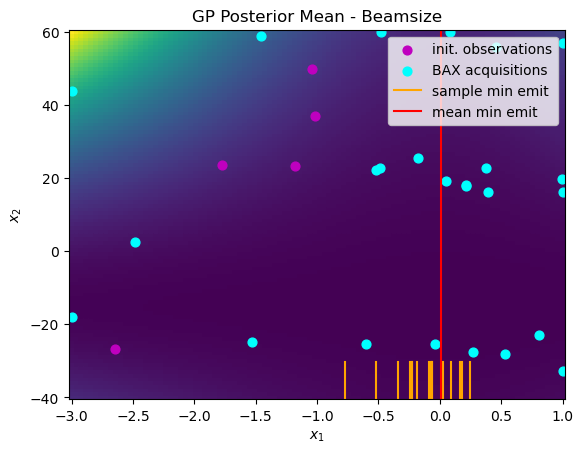

In [6]:
fig, ax = plt.subplots(1)

nsteps_mesh = 100
xs_mesh_n_by_d, x_mesh_tuple = build_mesh_domain(nsteps_mesh, domain)
x0mesh, x1mesh = x_mesh_tuple
p = acq_fn_i.model.posterior(xs_mesh_n_by_d)
ys_mesh = p.mean.reshape(nsteps_mesh,nsteps_mesh)
ax.pcolor(x0mesh.detach().numpy(), x1mesh.detach().numpy(), ys_mesh.detach().numpy())
ax.scatter(x_obs_i[:n_obs_init,0], x_obs_i[:n_obs_init,1], marker='o', s=40, color='m', label='init. observations')
ax.scatter(x_obs_i[n_obs_init:,0], x_obs_i[n_obs_init:,1], marker='o', s=40, color='cyan', label='BAX acquisitions')


ax.axvline(x_stars[0], ymax=0.1, c='orange', label='sample min emit')
for x_star in x_stars[1:]:
    ax.axvline(x_star, ymax=0.1, c='orange')

ax.axvline(X_tuning_star_i.flatten(), c='r', label='mean min emit')

ax.set_title('GP Posterior Mean - Beamsize')
ax.set_ylabel('$x_2$')
ax.set_xlabel('$x_1$')
ax.legend(loc='upper right')


# Perform a grid scan of the sample emittances along the single tuning parameter

In [7]:
X_tuning_scan = torch.linspace(*domain[0],100)
X_tuning_scan = X_tuning_scan.reshape(-1,1)
emits = post_emit(acq_fn_i.algo.post_paths, X_tuning_scan, acq_fn_i.algo.X_meas, samplewise=False, squared=True)

mean_emit = post_mean_emit(acq_fn_i.model, X_tuning_scan, acq_fn_i.algo.X_meas, squared=True)
x_pred, y_pred = acq_fn_i.algo.mean_output(acq_fn_i.model, num_restarts=8)


#compute ground truth emittance for comparison
true_emits_sq = (toy_emit_nd(X_tuning_scan)*1.e6)**2

# Plot the sample emittance grid scans along with the samplewise optimization results 

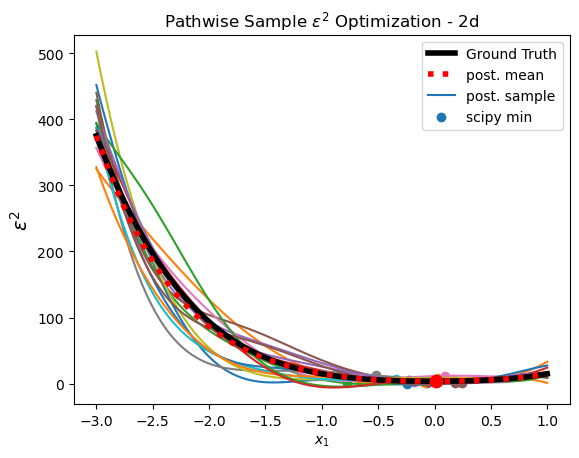

In [8]:
emit_stars = post_emit(acq_fn_i.algo.post_paths, torch.tensor(x_stars), acq_fn_i.algo.X_meas, samplewise=True, squared=True)


p = plt.plot(X_tuning_scan.flatten(), true_emits_sq, c='k', linewidth = 4, label='Ground Truth', zorder=28)
    
p = plt.plot(X_tuning_scan.flatten(), mean_emit.detach().numpy(), c='r', linewidth = 4, linestyle=':', label='post. mean', zorder=29)
plt.scatter(x_pred.flatten(), y_pred.flatten().detach(), c='r', s=80, zorder=30)


p = plt.plot(X_tuning_scan.flatten(), emits[0].detach().numpy(), label='post. sample')
x_star = x_stars[0]
emit_star = emit_stars[0]
plt.scatter([x_star[0]],[emit_star.detach().numpy()], c=p[-1].get_color(), label='scipy min')

for i in range(1, n_samples):
    p = plt.plot(X_tuning_scan.flatten(), emits[i].detach().numpy())
    x_star = x_stars[i]
    emit_star = emit_stars[i]
    plt.scatter([x_star[0]],[emit_star.detach().numpy()], c=p[-1].get_color())



plt.title('Pathwise Sample $\epsilon^2$ Optimization - 2d')
plt.xlabel('$x_1$')
plt.ylabel('$\epsilon^{2}$', fontsize=14)
plt.legend()

# Plot posterior sample beamsize results heatmap (2d)

Text(0.05, 0.95, 'sample 0')

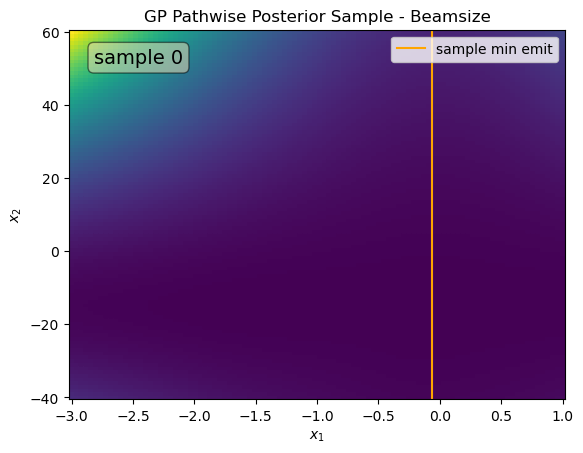

In [9]:
#Select sample:
sid = 0 #sample index


fig, ax = plt.subplots(1)

nsteps_mesh = 100
xs_mesh_n_by_d, x_mesh_tuple = build_mesh_domain(nsteps_mesh, domain)
x0mesh, x1mesh = x_mesh_tuple
ys_mesh = acq_fn_i.algo.post_paths(xs_mesh_n_by_d).reshape(acq_fn_i.algo.n_samples,nsteps_mesh,nsteps_mesh)
ax.pcolor(x0mesh.detach().numpy(), x1mesh.detach().numpy(), ys_mesh[sid].detach().numpy())
# ax.scatter(*xs_star[sid], marker='x', s=120, color='r', label='scipy min')


ax.axvline(x_stars[sid], c='orange', label='sample min emit')

ax.set_title('GP Pathwise Posterior Sample - Beamsize')
ax.set_ylabel('$x_2$')
ax.set_xlabel('$x_1$')
ax.legend(loc='upper right')

textstr = 'sample ' + str(sid)


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment = 'left', bbox=props)

# Plot Convergence Results vs. Step Number

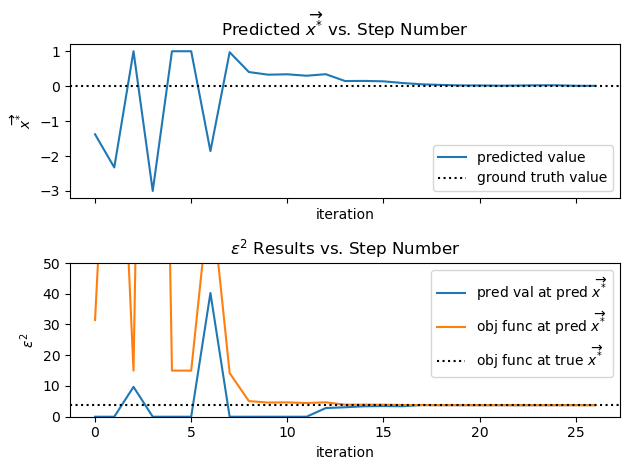

In [11]:
model_0 = iter_data[0]['model']
x_preds, y_preds = algo.mean_output(model_0)
for j in range(n_iter+1):
    model_j = iter_data[j]['model']
    x_pred_j, y_pred_j = algo.mean_output(model_j)
    x_preds = torch.cat((x_preds, x_pred_j), dim=0)
    y_preds = torch.cat((y_preds, y_pred_j), dim=0)
    
    

true_x_star = torch.tensor([[0.]*(ndim-1)])
true_emit_star = toy_emit_nd(true_x_star)*1.e6

fig, axs = plt.subplots(2, sharex=True)

ax = axs[0]

ax.set_title('Predicted $\overrightarrow{x^{*}}$ vs. Step Number')

ax.plot(x_preds.flatten(), label='predicted value')
ax.axhline(0, c='k', linestyle=':', label='ground truth value')

ax.set_xlabel('iteration')
ax.set_ylabel('$\overrightarrow{x^{*}} $')
ax.legend()




ax = axs[1]

ax.set_title('$\epsilon^{2}$ Results vs. Step Number')

ax.plot(torch.clamp(y_preds.detach().flatten(), min=0), label='pred val at pred $\overrightarrow{x^{*}} $')
ax.set_ylabel('$\epsilon^{2}$')
ax.set_xlabel('iteration')

ax.plot((toy_emit_nd(x_preds)*1.e6)**2, label='obj func at pred $\overrightarrow{x^{*}} $')
ax.axhline(true_emit_star**2, c='k', linestyle=':', label='obj func at true $\overrightarrow{x^{*}} $')

ax.set_ylim(0,50)
ax.legend()


plt.tight_layout()